# Bwamin VS BWA Benchmark

Note: Bwamin --mem --sw will fail for Large + files. DO NOT RUN!

## Table of Contents
Note: Click to jump to section
1. [Installation Check](#installation)
2. [Time Section](#time)
    1. BWT
    2. SW
    3. BWA
    4. Graphs
3. [Memory Section](#memory)
    1. BWT
    2. SW
    3. BWA
    4. Graphs
4. [Conclusions](#conclusions)

## Installation Check <a name="installation"></a>

In [1]:
%%capture
!echo hi
# Run this cell to make capture small again

Let's check if BWA and Bwamin are installed

In [2]:
!bwa


Program: bwa (alignment via Burrows-Wheeler transformation)
Version: 0.7.17-r1198-dirty
Contact: Heng Li <hli@ds.dfci.harvard.edu>

Usage:   bwa <command> [options]

Command: index         index sequences in the FASTA format
         mem           BWA-MEM algorithm
         fastmap       identify super-maximal exact matches
         pemerge       merge overlapping paired ends (EXPERIMENTAL)
         aln           gapped/ungapped alignment
         samse         generate alignment (single ended)
         sampe         generate alignment (paired ended)
         bwasw         BWA-SW for long queries (DEPRECATED)

         shm           manage indices in shared memory
         fa2pac        convert FASTA to PAC format
         pac2bwt       generate BWT from PAC
         pac2bwtgen    alternative algorithm for generating BWT
         bwtupdate     update .bwt to the new format
         bwt2sa        generate SA from BWT and Occ

Note: To use BWA, you need to first index the genome with `b

In [3]:
!python bwamin.py -h

usage: bwamin.py [-h] [--index] [--mem] [--bwt] [--sw] [--fasta FASTA]
                 [--fastq FASTQ] [-A A] [-B B] [-O O] [-E E] [-out OUT]

minimum bwa

optional arguments:
  -h, --help            show this help message and exit
  --index               index a fasta file
  --mem                 index a fasta file
  --bwt                 enables Burrow-Wheeler Transform search
  --sw                  enables Smith-Waterman search
  --fasta FASTA, --fa FASTA
                        fasta input
  --fastq FASTQ, --fq FASTQ
                        fastq input
  -A A                  Matching score. [1]
  -B B                  Mismatch penalty. The sequence error rate is
                        approximately: {.75 * exp[-log(4) * B/A]}. [4]
  -O O                  Gap open penalty. [6]
  -E E                  Gap extension penalty. A gap of length k costs O + k*E
                        (i.e. -O is for opening a zero-length gap). [1]
  -out OUT              Specify output file


## Time Section <a name="time"></a>

We will test bwamin bwt, bwamin sw, and bwa on a custom
short, and longer files.

In [4]:
# Helper commands so we can graph later
import pandas as pd
import seaborn as sns

# Change string to seconds
def timing(string):
    if type(string) == type(0.01):
        return string
    elements = string.split('m')
    minutes = elements[0]
    seconds = elements[1]

    seconds = seconds.replace('s', '')
    minues = minutes.strip()
    seconds = seconds.strip()

    if not minutes.isnumeric() or seconds.isnumeric():
        print('ERROR')

    return (float(minutes) * 60 + float(seconds))
    
def convertTime(filename):
    if '.txt' not in filename:
        filename = filename + '.txt'
    x = pd.read_csv(filename, sep='\t', header=None)
    x[1] = x[1].apply(timing)
    x.to_csv(filename, header=False, index=False, sep='\t')     
    
# Summing the time with index and mem to one file
def addTime(filename):
    # Read files
    x = pd.read_csv(filename + "Index.txt", sep='\t', header=None)
    y = pd.read_csv(filename + "Mem.txt", sep='\t', header=None)
    
    # Convert and add times
    x[1] = x[1].apply(timing)
    y[1] = y[1].apply(timing)
    x[1] = x[1] + y[1]
    
    # Write to file
    x.to_csv(filename + '.txt', header=False, index=False, sep='\t') 
    
def convertSec(filename):
    if '.txt' not in filename:
        filename = filename + '.txt'
    x = pd.read_csv(filename, sep='\t', header=None)
    x[1] = x[1].apply(timing)
    return x[1][0]
    
def addSec(filename):
    # Read files
    x = pd.read_csv(filename + "Index.txt", sep='\t', header=None)
    y = pd.read_csv(filename + "Mem.txt", sep='\t', header=None)
    # Convert and add times
    x[1] = x[1].apply(timing)
    y[1] = y[1].apply(timing)
    x[1] = x[1] + y[1]
    return x[1][0]

In [5]:
# Initiallize the values total time
bwt = [0 for i in range(5)]
sw = [0 for j in range(5)]
bwa = [0 for k in range(5)]


### Short

In [6]:
# Peak at short reference and read
print('short.fa')
!head benchmark/testfiles/short.fa
print('\n\nshort.fq')
!head benchmark/testfiles/short.fq

short.fa
>chr1
TGCAA

short.fq
@Sample1
TCAT
+
!1=D

In [7]:
%%capture
# Bwt
!{ time python bwamin.py --index --bwt --fa benchmark/testfiles/short.fa \
  2> sleep.stderr ;} 2> benchmark/testfiles/bwaminBwtShortTimeIndex.txt
!{ time python bwamin.py --mem --bwt --fa benchmark/testfiles/short.fa \
  --fq benchmark/testfiles/short.fq -out benchmark/testfiles/bwtshort.sam \
  2> sleep.stderr ;} 2> benchmark/testfiles/bwaminBwtShortTimeMem.txt
bwt[0] = addSec('benchmark/testfiles/bwaminBwtShortTime')

# Sw
!{ time python bwamin.py --mem --sw --fa benchmark/testfiles/short.fa\
  --fq benchmark/testfiles/short.fq -out benchmark/testfiles/swshort.sam\
  2> sleep.stderr ;} 2> benchmark/testfiles/bwaminSwShortTime.txt
sw[0] = convertSec('benchmark/testfiles/bwaminSwShortTime.txt')

# Bwa
!{ time bwa index benchmark/testfiles/short.fa \
  2> sleep.stderr ;} 2> benchmark/testfiles/bwaShortTimeIndex.txt
!{ time bwa mem benchmark/testfiles/short.fa \
  benchmark/testfiles/short.fq > benchmark/testfiles/bwashort.sam\
  2> sleep.stderr ;} 2> benchmark/testfiles/bwaShortTimeMem.txt
bwa[0] = addSec('benchmark/testfiles/bwaShortTime')

In [8]:
# Print Short Results
# print('Bwt')
# !cat benchmark/testfiles/bwaminBwtShortTime.txt
# print('\nSw')
# !cat benchmark/testfiles/bwaminSwShortTime.txt
# print('\nBwa')
# !cat benchmark/testfiles/bwaShortTime.txt

Bwt
real	1.721
user	1.116
sys	0.362

Sw

real	0m0.240s
user	0m0.196s
sys	0m0.039s

Bwa
real	0.033
user	0.006
sys	0.013


In [ ]:
print(bwt)
print(sw)
print(bwa)

## Medium

In [9]:
# Peak at medium reference and read
print('testfastring.fa')
!head benchmark/testfiles/testfastring.fa
print('\n\ntestfqstring.fq')
!head benchmark/testfiles/testfqstring.fq

testfastring.fa
>chr1
ATCCTATATTACGACTTTGGCAGGGGGTTCGCAAGTCCCACCCCAAACGATGCTGAAGGCTCAGGTTACACAGGCACAAGTACTATATATACGAGTTCCCGCTCTTAACCTGGATCGAATGCAGAATCATGCATCGTACCACTGTGTTCGTGTCATCTAGGACGGGCGCAAAGGATATATAATTCAATTAAGAATACCTTATATTATTGTACACCTACCGGTCACCAGCCAACAATGTGCGGATGGCGTT
>chr2
ACGACTTACTGGGCCTGATCTCACCGCTTTAGATACCGCACACTGGGCAATACGAGGTAAAGCCAGTCACCCAGTGTCGATCAACAGCTAACGTAACGGTAAGAGGCTCACAAAATCGCACTGTCGGCGTCCCTTGGGTATTTTACGTTAGCATCAGGTGGACTAGCATGAATCTTTACTCCCAGGCGAAAACGGGTGCGTGGACAAGCGAGCAGCAAACGAAAATTCTTGGCCTGCTTGGTGTCTCGTA

testfqstring.fq
@SRR5077691.13
NTGAAAAGATGTCTCCTTCTGTAAGTCAGAACAAAAAACTTTAATTAACT
+
!1=DDFFFHHHHGJJJJJJJJIJJJIIIJIHGIJJJJJJJJJFHHIJIJI
@SRR5077691.79
GTTTCATTGTGTCTTTATTTCCTGTATTAATGAGATGGGATATGAAGTCT
+
JJJJJJJIJJIJJJJJJJJIHJJJJJJJJJJJJJJJJHHHHHFFFFF@CB
@SRR5077691.32
GCCGTGTGCCCCCTCTTGGGTGACACCCCACCCCACCCTTATTTGCATCN


In [10]:
%%capture
# Bwt
!{ time python bwamin.py --index --bwt --fa benchmark/testfiles/testfastring.fa 2> sleep.stderr ;} 2> benchmark/testfiles/bwaminBwtMedTimeIndex.txt
!{ time python bwamin.py --mem --bwt --fa benchmark/testfiles/testfastring.fa --fq benchmark/testfiles/testfqstring.fq -out benchmark/testfiles/bwttest.sam 2> sleep.stderr ;} 2> benchmark/testfiles/bwaminBwtMedTimeMem.txt
bwt[1] = addSec('benchmark/testfiles/bwaminBwtMedTime')

# Sw
!{ time python bwamin.py --mem --sw\
  --fa benchmark/testfiles/testfastring.fa\
  --fq benchmark/testfiles/testfqstring.fq \
  -out benchmark/testfiles/swtest.sam \
  2> sleep.stderr ;} 2> benchmark/testfiles/bwaminSwMedTime.txt
sw[1] = convertSec('benchmark/testfiles/bwaminSwMedTime.txt')

# Bwa
!{ time bwa index benchmark/testfiles/testfastring.fa 2> sleep.stderr ;} 2> benchmark/testfiles/bwaMedTimeIndex.txt
!{ time bwa mem benchmark/testfiles/testfastring.fa\
  benchmark/testfiles/testfqstring.fq > benchmark/testfiles/bwatest.sam 2> sleep.stderr ;} 2> benchmark/testfiles/bwaMedTimeMem.txt
bwa[1] = addSec('benchmark/testfiles/bwaMedTime')

In [11]:
# Print Medium Results
# print('Bwt')
# !cat benchmark/testfiles/bwaminBwtMedTime.txt
# print('\nSw')
# !cat benchmark/testfiles/bwaminSwMedTime.txt
# print('\nBwa')
# !cat benchmark/testfiles/bwaMedTime.txt

Bwt
real	1.3860000000000001
user	1.02
sys	0.295

Sw

real	0m0.573s
user	0m0.521s
sys	0m0.047s

Bwa
real	0.043
user	0.007
sys	0.014


In [ ]:
print(bwt)
print(sw)
print(bwa)

### Long

This is an Ebola Virus found using sra.

In [12]:
# Peak at long reference and read
print('SRR10769501.fasta.fixed')
!head -n 4 benchmark/mydata/SRR10769501.fasta.fixed
print('\n\nSRR10769501.fastq')
!head -n 4 benchmark/mydata/SRR10769501.fastq

SRR10769501.fasta.fixed
>@SRR10769501.1.1 M02486:32:000000000-BTHFB:1:1101:16201:1720 length=160
GCCGTAGCCCTGCTCGCCAGCGCGTAGCGGTGTCGTTTCCGTAGCGTCATCTTCGTCATCATTATTTCCAGTGGGTTCCTCGTTTTCACTCGCATTCGTGTCTTCGTCTTCCACCTTGCGAACAAAGTCTTTCTTCCCCCGGATCGCAAAGAGCTCCAGC
>@SRR10769501.2.1 M02486:32:000000000-BTHFB:1:1101:21365:1807 length=160
GGGCTTCACGGGCTTGCGGCGTTTCCACGCCGTGGTCAACGGCGTTGCGCAGCAGGTGGCCCAGCGGGGCATCGAGCATCTGTCTCTTATACACATCTCCGACCCCACTCTACAGGCACAAATCTCCTATTCCGTCTTCTTCTTTAAAACAAAAACCCCC


SRR10769501.fastq
@SRR10769501.1.1 M02486:32:000000000-BTHFB:1:1101:16201:1720 length=160
GCCGTAGCCCTGCTCGCCAGCGCGTAGCGGTGTCGTTTCCGTAGCGTCATCTTCGTCATCATTATTTCCAGTGGGTTCCTCGTTTTCACTCGCATTCGTGTCTTCGTCTTCCACCTTGCGAACAAAGTCTTTCTTCCCCCGGATCGCAAAGAGCTCCAGC
+SRR10769501.1.1 M02486:32:000000000-BTHFB:1:1101:16201:1720 length=160
????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????


In [13]:
%%capture
# Bwt
# Note file too big will not run
# !{ time python bwamin.py --index --bwt\
#   --fa benchmark/mydata/SRR10769501.fasta.fixed \
#   2> sleep.stderr ;} \
#   2> benchmark/mydata/bwaminBwtLongTimeIndex.txt
# !{ time python bwamin.py --mem --bwt\
#   --fa benchmark/mydata/SRR10769501.fasta.fixed\
#   --fq benchmark/mydata/SRR10769501.fastq \
#   2> sleep.stderr ;} \
#   2> benchmark/mydata/bwaminBwtLongTimeMem.txt
# addTime('benchmark/mydata/bwaminBwtLongTime')



In [14]:
%%capture
# NOTE: This process will be killed even with 48GB, Don't run
# Sw
# !{ time python bwamin.py --mem --sw\
#   --fa benchmark/mydata/SRR10769501.fasta.fixed\
#   --fq benchmark/mydata/SRR10769501.fastq -out swlong.sam\
#   2> sleep.stderr ;} 2> benchmark/mydata/bwaminSwLongTime.txt
# convertTime('benchmark/mydata/bwaminSwLongTime.txt')

In [15]:
%%capture
# Bwa
!{ time bwa index benchmark/mydata/SRR10769501.fasta.fixed \
  2> sleep.stderr ;} 2> benchmark/mydata/bwaLongTimeIndex.txt
!{ time bwa mem benchmark/mydata/SRR10769501.fasta.fixed\
  benchmark/mydata/SRR10769501.fastq > benchmark/mydata/bwalong.sam\
  2> sleep.stderr ;} 2> benchmark/mydata/bwaLongTimeMem.txt
bwa[2] = addSec('benchmark/mydata/bwaLongTime')

In [16]:
#Print Short Results
# print('Bwt')
# !cat benchmark/mydata/bwaminBwtLongTime.txt
# print('\nSw')
# !cat benchmark/mydata/bwaminSwLongTime.txt
# print('\nBwa')
# !cat benchmark/mydata/bwaLongTime.txt

Bwt
cat: benchmark/mydata/bwaminBwtLongTime.txt: No such file or directory

Sw
cat: benchmark/mydata/bwaminSwLongTime.txt: No such file or directory

Bwa
real	12.486
user	11.892
sys	0.307


In [ ]:
print(bwt)
print(sw)
print(bwa)

## Ebola Virus 

I found a smaller one with only 19kbases

In [24]:
# SRR10083456.fastq
#bwt
!{ time python bwamin.py --index --bwt\
  --fa benchmark/mydata/SRR10083456.fasta \
  2> sleep.stderr ;} \
  2> benchmark/mydata/bwaminBwtEbolaTimeIndex.txt

!{ time python bwamin.py --mem --bwt\
  --fa benchmark/mydata/SRR10083456.fastq\
  --fq benchmark/mydata/SRR10083456.fastq \
  -out benchmark/mydata/bwtebola.sam 2> sleep.stderr ;} \
  2> benchmark/mydata/bwaminBwtEbolaTimeMem.txt
bwt[3] = addSec('benchmark/mydata/bwaminBwtEbolaTime')

Note: Sw is slow on this one

In [23]:
# Sw KILLED
# !{ time python bwamin.py --mem --sw\
#   --fa benchmark/mydata/SRR10083456.fasta\
#   --fq benchmark/mydata/SRR10083456.fastq -out swebola.sam\
#   2> sleep.stderr ;} 2> benchmark/mydata/bwaminSwEbolaTime.txt
# sw[3] = convertSec('benchmark/mydata/bwaminSwEbolaTime.txt')

In [19]:
%%capture
# Bwa
!{ time bwa index benchmark/mydata/SRR10083456.fasta \
  2> sleep.stderr ;} 2> benchmark/mydata/bwaEbolaTimeIndex.txt

!{ time bwa mem benchmark/mydata/SRR10083456.fasta\
  benchmark/mydata/SRR10083456.fastq > benchmark/mydata/bwaebola.sam\
  2> sleep.stderr ;} 2> benchmark/mydata/bwaEbolaTimeMem.txt
bwa[3] = addSec('benchmark/mydata/bwaEbolaTime')

In [ ]:
#Print Ebola Results
print('Bwt')
!cat benchmark/mydata/bwaminBwtEbolaTime.txt
print('\nSw')
!cat benchmark/mydata/bwaminSwEbolaTime.txt
print('\nBwa')
!cat benchmark/mydata/bwaEbolaTime.txt

In [20]:
print(bwt)
print(sw)
print(bwa)

[0.481, 0.5780000000000001, 0, 0.749, 0]
[0.24, 0.573, 0, 0, 0]
[0.019, 0.023, 7.239, 0.052000000000000005, 0]


### In-Class sample
We have chromsome 17 from a mouse as the reference and the reads come from Sox2. This was found in lab 5. Although this is the smallest example in class, my tools could not complete it.

Note: Just like in the Long section, BWT and SW will not run to completion due to low memory. They both get killed in the process.

In [21]:
%%capture
# Bwa
!{ time bwa index benchmark/classExample/GRCm38.chr17.fa \
  2> sleep.stderr ;} 2> benchmark/mydata/bwaClassTimeIndex.txt

!{ time bwa mem benchmark/classExample/GRCm38.chr17.fa\
  benchmark/mydata/Sox2.fastq > benchmark/mydata/bwaclass.sam\
  2> sleep.stderr ;} 2> benchmark/mydata/bwaClassTimeMem.txt
bwa[4] = addSec('benchmark/mydata/bwaClassTime')

In [25]:
print(bwt)
print(sw)
print(bwa)

[0.481, 0.5780000000000001, 0, 0.741, 0]
[0.24, 0.573, 0, 0, 0]
[0.019, 0.023, 7.239, 0.052000000000000005, 74.496]


# Graphs

In [30]:
# Fasta file size
!ls -l benchmark/testfiles/short.fa
!ls -l benchmark/testfiles/testfastring.fa
!ls -l benchmark/mydata/SRR10769501.fasta
!ls -l benchmark/mydata/SRR10083456.fasta
!ls -l benchmark/classExample/GRCm38.chr17.fa

-rw-rw---- 1 ndtorres root 11 Jun  7 06:54 benchmark/testfiles/short.fa
-rw-rw---- 1 ndtorres root 513 Jun  7 06:54 benchmark/testfiles/testfastring.fa
-rw-rw---- 1 ndtorres root 7503235 Jun  5 17:54 benchmark/mydata/SRR10769501.fasta
-rw-rw---- 1 ndtorres root 19020 Jun  7 11:08 benchmark/mydata/SRR10083456.fasta
-rwxr-x--- 1 ndtorres root 96887024 Jun  7 15:30 benchmark/classExample/GRCm38.chr17.fa


In [31]:
# Fastq file size
!ls -l benchmark/testfiles/short.fq
!ls -l benchmark/testfiles/testfqstring.fq
!ls -l benchmark/mydata/SRR10769501.fastq
!ls -l benchmark/mydata/SRR10083456.fastq
!ls -l benchmark/classExample/Sox2.fastq

-rw-rw---- 1 ndtorres root 20 Jun  7 06:54 benchmark/testfiles/short.fq
-rw-rw---- 1 ndtorres root 1076 Jun  7 06:54 benchmark/testfiles/testfqstring.fq
-rw-rw---- 1 ndtorres root 15006470 Jun  5 17:54 benchmark/mydata/SRR10769501.fastq
-rw-rw---- 1 ndtorres root 38039 Jun  7 11:08 benchmark/mydata/SRR10083456.fastq
-rw-rw---- 1 ndtorres root 1916 Jun  7 15:33 benchmark/classExample/Sox2.fastq


In [32]:
fastaSize = [11, 513, 7503235, 19020, 96887024]
fastqSize = [20, 1076, 15006470, 38039, 1916]

In [110]:
import matplotlib.pyplot as plt
import numpy as np
times = pd.DataFrame(
    {'bwt': bwt,
     'sw': sw,
     'bwa': bwa,
     'faSize': fastaSize,
     'fqSize': fastqSize
    })
# times['productSize'] = times['faSize'] * times['fqSize']
# times = times.swapaxes('index','columns')
times

bwt     sw     bwa    faSize    fqSize
0  0.481  0.240   0.019        11        20
1  0.578  0.573   0.023       513      1076
2  0.000  0.000   7.239   7503235  15006470
3  0.741  0.000   0.052     19020     38039
4  0.000  0.000  74.496  96887024      1916

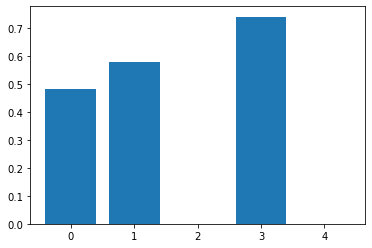

In [100]:
# times['bwt'].groupby(times.index).size().plot(kind='bar')
plt.bar([0,1,2,3,4], bwt)
plt.show()

<AxesSubplot:>

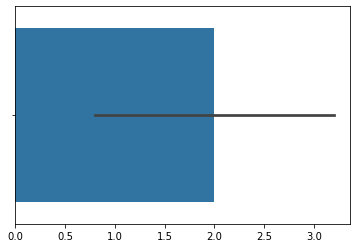

In [90]:
sns.barplot(data=times, x=times.index, hue=times.columns)


## Conclusion
